# Neptune + Sacred

## Before you start

### Install dependecies

In [ ]:
!pip install --q neptune-client[sacred] sacred==0.8.2 torch==1.9.0 torchvision==0.10.0

# Basic Example

Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sacred import Experiment

In [ ]:
import neptune.new as neptune
from neptune.new.integrations.sacred import NeptuneObserver

In [ ]:
if torch.device("cuda:0"):
    torch.cuda.empty_cache()

## Step 1: Create a Neptune run

To log metadata to the Neptune project, you need the `project name` and the `api_token`.

To make this example easy to follow, we have created a public project **'common/sacred-integration'** and a shared user **'neptuner'** with the API token **'ANONYMOUS'**. As you will see in the code cell below.

**(Optional)** To log to your Neptune project:

* [Create a Neptune account](https://app.neptune.ai/register/)

* [Find your API token](https://docs.neptune.ai/getting-started/installation#authentication-neptune-api-token)
* [Find your project name](https://docs.neptune.ai/getting-started/installation#setting-the-project-name)

Pass your credentials to project and api_token arguments of neptune.init()

`run = neptune.init(api_token='<YOUR_API_TOKEN>', project='<YOUR_WORKSPACE/YOUR_PROJECT>')` # pass your credentials


In [ ]:
neptune_run = neptune.init(
    project='common/sacred-integration', 
    api_token = 'ANONYMOUS',
    tags = 'notebook'
)

## Step 2: Add NeptuneObserver() to your sacred experiment's observers
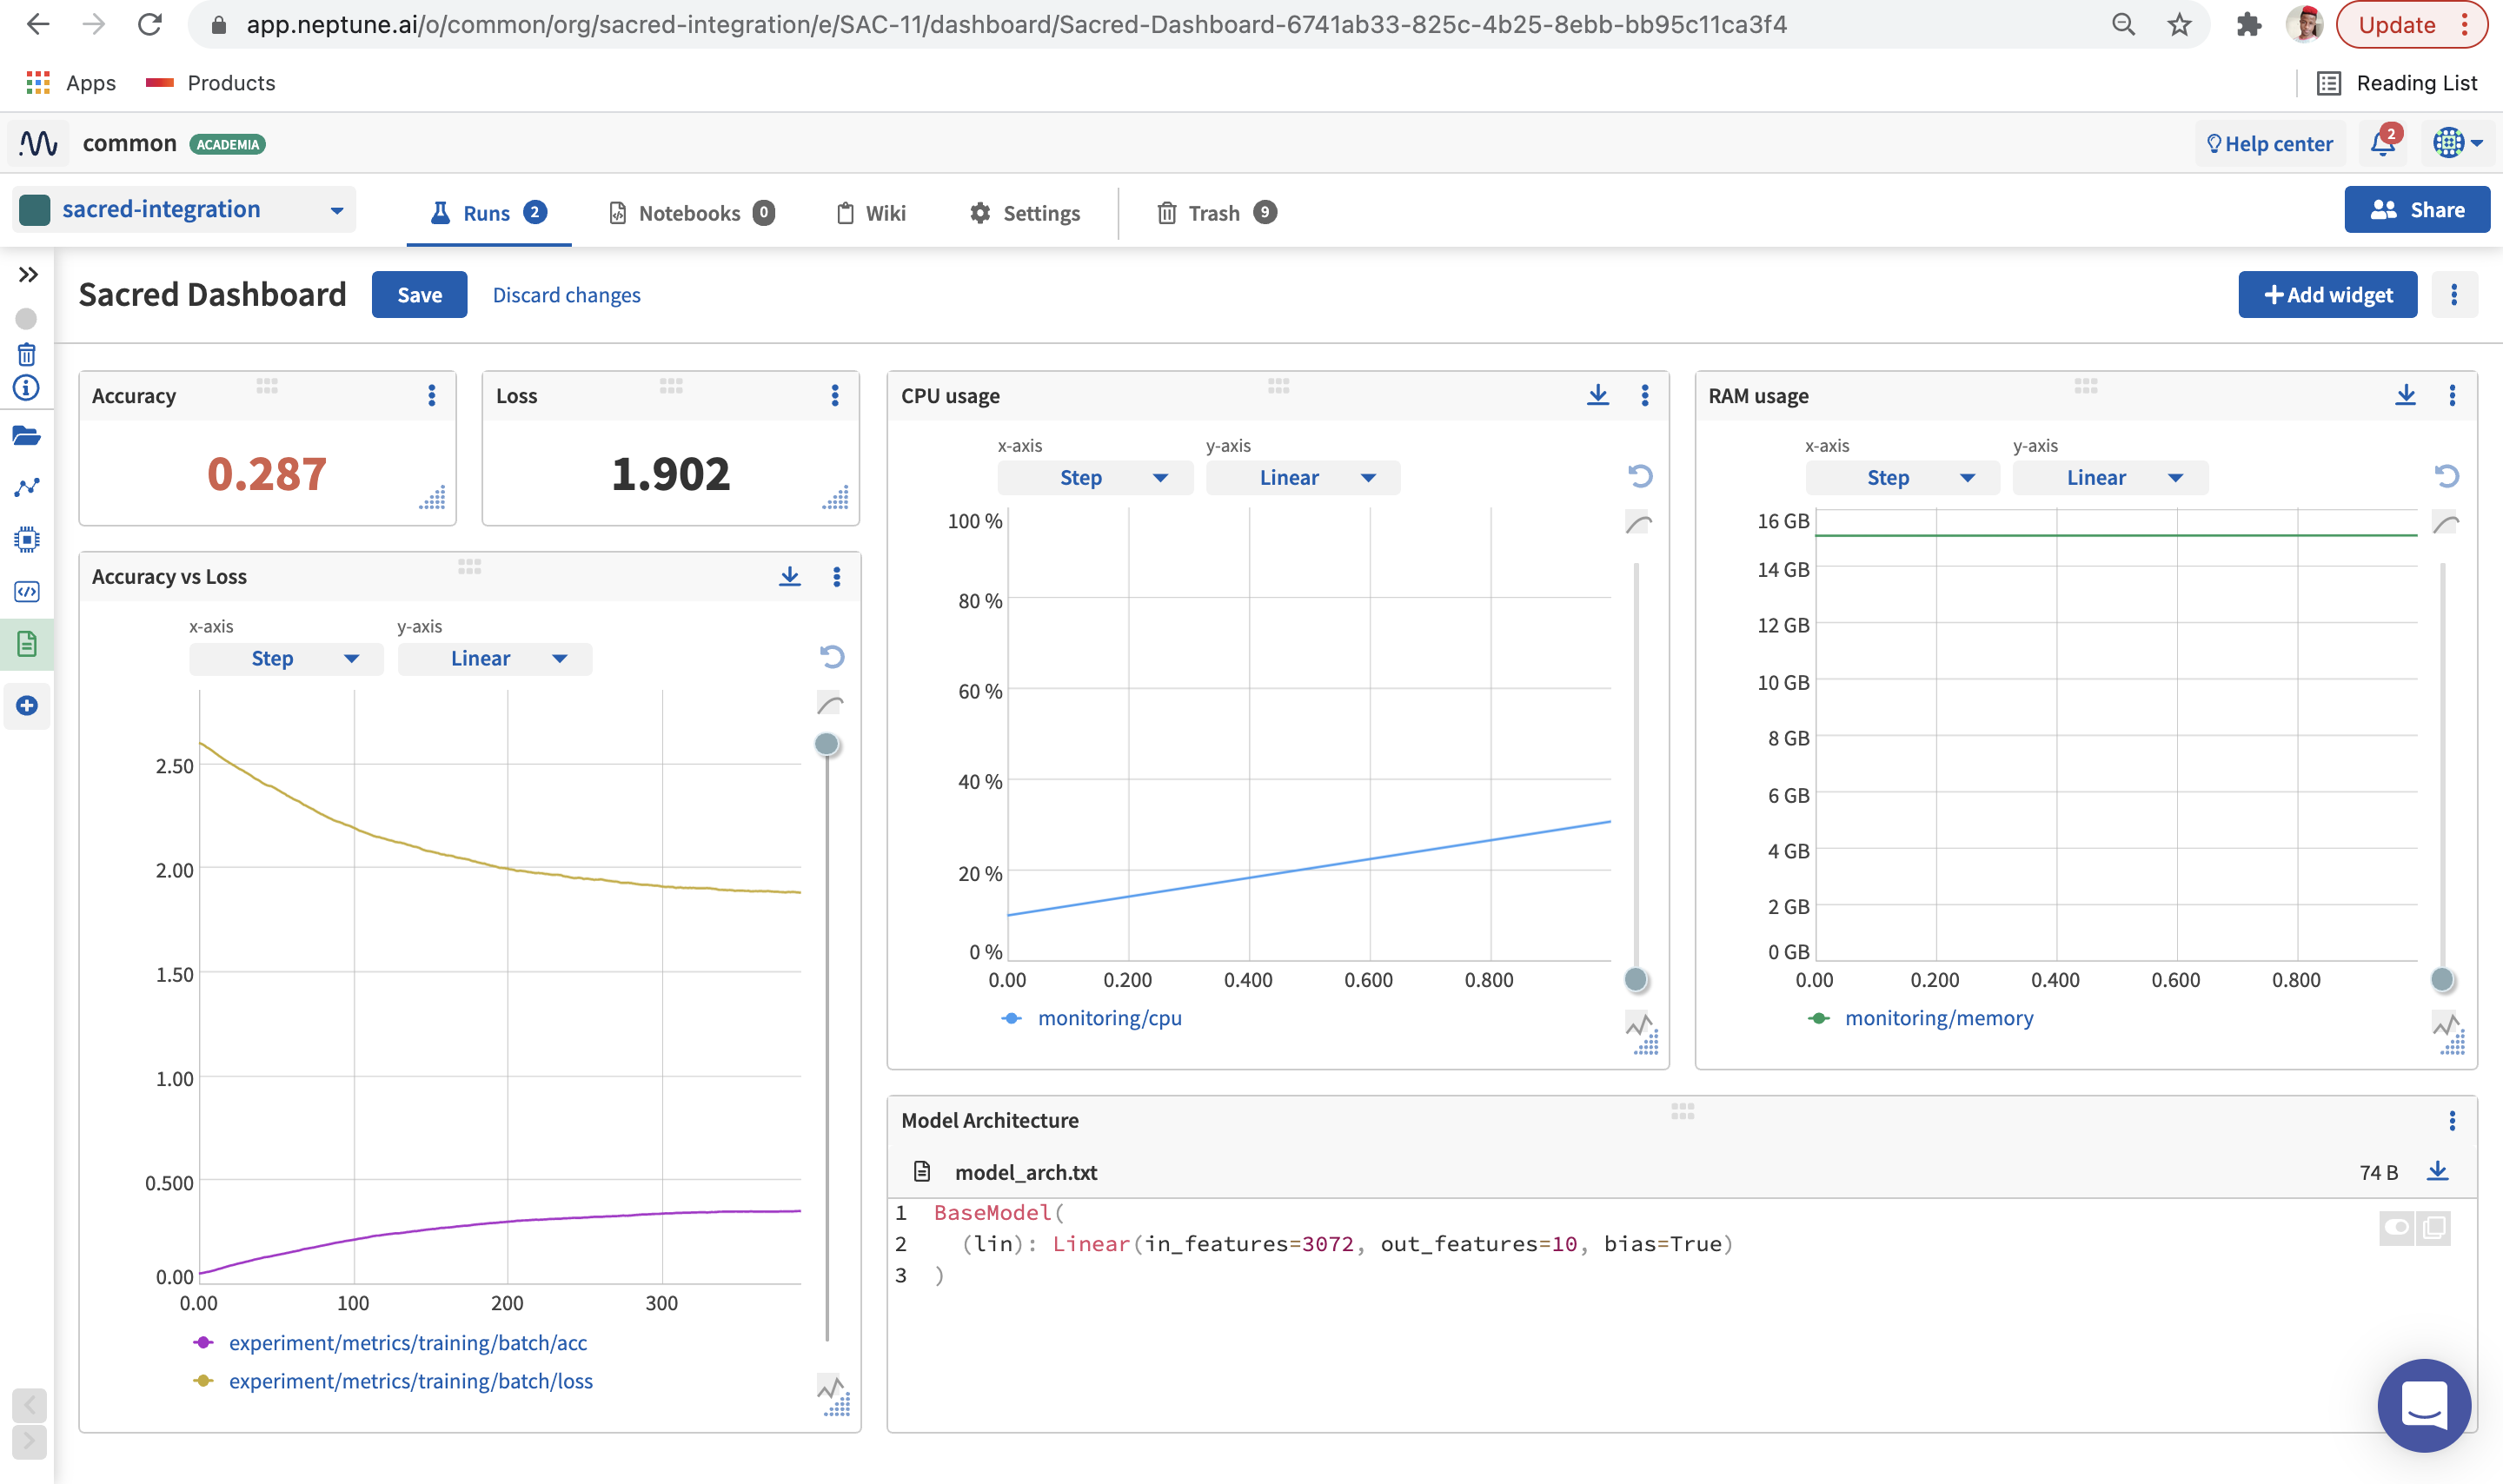
Dashboard: https://app.neptune.ai/o/common/org/sacred-integration/e/SAC-11/dashboard/Sacred-Dashboard-6741ab33-825c-4b25-8ebb-bb95c11ca3f4

Using NeptuneObsever the following is automatically logged to Neptune UI for you:
- Hyperparameters
- Loss
- Metrics


In [ ]:
ex = Experiment('image_classification', interactive=True)
ex.observers.append(NeptuneObserver(run=neptune_run))

Define Model

In [ ]:
class BaseModel(nn.Module):
    def __init__(self, input_sz = 32 * 32 * 3, n_classes = 10):
        super(BaseModel, self).__init__()
        self.lin = nn.Linear(input_sz, n_classes)


    def forward(self, input):
        x = input.view(-1, 32 * 32 * 3)
        return self.lin(x)


In [ ]:
model = BaseModel()

Define your configuration/hyperparamenters

In [ ]:
@ex.config
def cfg():
    data_dir = 'data/CIFAR10'
    data_tfms = {
        'train': transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }
    lr = 1e-2
    bs = 128
    n_classes = 10
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Define your run

In [ ]:
@ex.main
def run(data_dir, data_tfms, input_sz, n_classes, lr, bs, device, _run):
    
    trainset = datasets.CIFAR10(data_dir, transform=data_tfms['train'], 
                                download=True)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                              shuffle=True, num_workers=2)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)  
    for i, (x, y) in enumerate(trainloader, 0):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model.forward(x)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, y)
        acc = (torch.sum(preds == y.data)) / len(x)

        # Log loss
        ex.log_scalar("training/batch/loss", loss)
        # Log accuracy
        ex.log_scalar("training/batch/acc", acc)

        loss.backward()
        optimizer.step()
    
    return {'final_loss': loss.item(), 'final_acc': acc.cpu().item()}

## Step 3: Run your experiment and explore metadata in Neptune UI

All metadata is logged automatically to Neptune. 

After running your script or notebook cell you will get a link similar to:
https://app.neptune.ai/o/common/org/sacred-integration/e/SAC-1
with common/sacred-integration replaced by your project, and SAC-1 replaced by your run.

Click on the link to open the Run in Neptune to watch your model training live.

In [ ]:
ex.run()

# More Options

## Step 5: Log Artifacts

 - Model architecture and weights

In [ ]:
model_fname ='model'
print(f'Saving model archictecture as {model_fname}.txt')
with open(f'{model_fname}_arch.txt', 'w') as f:  f.write(str(model))

In [ ]:
print(f'Saving model weights as {model_fname}.pth')
torch.save(model.state_dict(), f'./{model_fname}.pth')

In [ ]:
ex.add_artifact(filename = model_fname+'_arch', name=f'./{model_fname}_arch.txt')
ex.add_artifact(filename = model_fname, name=f'./{model_fname}.pth')

# Stop logging
Once you are done logging, you should stop tracking the Run using the stop() method.

In [ ]:
neptune_run.stop()